Purpose of this notebook is to establish an own baselines on the T1626 Merck&Co+ dataset ***alone*** (with different subsests of features) using XGBoost with nested bayesian optimization.

For the current nomenclature of these "Merck&Co+ models" see the names in the brackets.

## Notebook Setup

In [0]:
#Imports:
import os
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import preprocessing
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import RepeatedKFold
import time
import datetime
import seaborn as sns
import pylab

In [0]:
#Connect to google drive:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
#Set up file paths:
data_folder_loc = "gdrive/My Drive/iGEM/Databases/Merck&Co/Data/T1626/own_baseline_xgboost_T1626/"
model_folder_loc = "gdrive/My Drive/iGEM/Databases/Merck&Co/Models/Paper_Features_Own_Baseline/"
y_target_loc = data_folder_loc + "y_label_own_baseline_xgboost_T1626.pkl"
X_paper_loc =  data_folder_loc + "X_paper_own_baseline_xgboost_T1626.pkl"
X_paper_ext_loc =  data_folder_loc + "X_paper_ext_own_baseline_xgboost_T1626.pkl"
X_paper_cart_tie_loc =  data_folder_loc + "X_paper_ALG_CART_tiE_own_baseline_xgboost_T1626.pkl"
unambiguous_sequence_mut_filter_loc = "gdrive/My Drive/iGEM/Databases/Merck&Co/Data/T1626/sequence_sampler_T1626/unambiguous_mut_filter_T1626.csv"
print(os.path.isdir(data_folder_loc))
print(os.path.isdir(model_folder_loc))
print(os.path.isfile(y_target_loc))
print(os.path.isfile(X_paper_loc))
print(os.path.isfile(X_paper_ext_loc))
print(os.path.isfile(unambiguous_sequence_mut_filter_loc))

True
True
True
True
True
True


In [0]:
#XGBoost
!pip install xgboost==0.82 #working GPU support
import xgboost as xgb

     |████████████████████████████████| 114.0MB 290kB/s 
  Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90


In [0]:
#BayersianOptimization
!pip install bayesian-optimization
from bayes_opt import BayesianOptimization

  Stored in directory: /root/.cache/pip/wheels/1d/0d/3b/6b9d4477a34b3905f246ff4e7acf6aafd4cc9b77d473629b77
Successfully built bayesian-optimization


## Prepare Data

In [0]:
#Just load data
y_label = pd.read_pickle(y_target_loc) 
X_paper = pd.read_pickle(X_paper_loc) 
X_paper_ext = pd.read_pickle(X_paper_ext_loc) 
X_paper_cart_tie = pd.read_pickle(X_paper_cart_tie_loc) 
unambiguous_mut_filter = pd.read_csv(unambiguous_sequence_mut_filter_loc)["Unambiguous"].values

## Supplementary functions

In [0]:
def n_trial_nested_k_fold_crossvalidation(data_x, data_y, num_trials=7, eval_metric="mae", scale_label=False, inner_fold=3, outer_fold=5, bayes_init_points=15, bayes_iterations=10, bayes_acquisition_function='ei', repeated_k_fold_seed=42375):  
  print("Trials: ", num_trials)
  print("Evaluation metric: ", eval_metric)
  print("Inner folds: ", inner_fold)
  print("Outer folds: ", outer_fold)
  print("Bayesian init points: ", bayes_init_points)
  print("Bayesian iterations: ", bayes_iterations)
  print("Bayes acquisition function: ", bayes_acquisition_function)

  # Variable for xgb_evalutate, unfortunately cannot be a direct argument
  bayesian_training_data = None
  # Supplementary function for hyperparameter tuning. Corresponds in essense to inner cross validation.
  def xgb_evaluate(max_depth, gamma, colsample_bytree, subsample, eta):
      params = {'eval_metric': eval_metric,
                'objective':'reg:linear',
                'tree_method': 'gpu_hist',
                'max_depth': int(max_depth),
                'eta': eta,
                'gamma': gamma,
                'colsample_bytree': colsample_bytree,
                'subsample': subsample}
      # This corresponds to the inner cross validation cycle for hyperparameter tuning:
      cv_result = xgb.cv(params, bayesian_training_data, num_boost_round=100, nfold=inner_fold)    
      # Bayesian optimization only knows how to maximize, not minimize, thus negate score:
      return -1.0 * cv_result['test-mae-mean'].iloc[-1]
    
  # Bounds for the bayesian optimization
  bay_bounds={'eta': (0.01, 0.3),
              'max_depth': (5, 10), 
              'gamma': (0.0, 1.0),
              'colsample_bytree': (0.5, 1.0),
              'subsample': (0.7, 1.0)}
    
  #saves result for each outer cross val
  scores_mae = [] 
  scores_rmse = []
  best_parameters = []

  total_fold_counter = 0
  rkf = RepeatedKFold(n_splits=outer_fold, n_repeats=num_trials, random_state=repeated_k_fold_seed)
  # Main loop for trials and outer outer cross_val
  for train_index, test_index in rkf.split(data_x):
    #Measure runtime
    start_time = time.time()
    
    # Print current status
    print("\nTrial number: ", (total_fold_counter//outer_fold)+1)
    print("Fold number: ", (total_fold_counter%outer_fold)+1)
    total_fold_counter += 1
    
    # Select current train and test data
    X_train, X_test = data_x[train_index], data_x[test_index]
    y_train, y_test = data_y[train_index], data_y[test_index]
    
    # Scale target label, if requested
    standard_scaler = preprocessing.StandardScaler()
    if scale_label:
      y_train = standard_scaler.fit_transform(y_train.reshape(-1, 1)).reshape((len(y_train))) #only fit on y_train to prevent information leakage
    
    # Prepare data for XGBoost
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test)
    
    # Bayesian optimize in 5 fold cross validation
    xgb_bo = BayesianOptimization(f=xgb_evaluate, 
                                  pbounds=bay_bounds,
                                  random_state=((total_fold_counter*repeated_k_fold_seed)%1000)) #create deterministic seed from outer_fold, num_trials and repeated_k_fold_seed
    bayesian_training_data = dtrain
    xgb_bo.maximize(init_points=bayes_init_points, n_iter=bayes_iterations, acq=bayes_acquisition_function) #default: 20,20,'ei'
    
    # Extract optimal parameters
    params_opt = xgb_bo.max['params']
    best_parameters.append(params_opt) #save best parameters
    params_opt['max_depth'] = int(params_opt['max_depth'])
    params_opt['eval_metric'] = eval_metric
    params_opt['objective'] = 'reg:linear'
    params_opt['tree_method'] = 'gpu_hist'
    
    # Train a new model with the best parameters from the search
    model = xgb.train(params_opt, dtrain, num_boost_round=1000)

    # Predict on testing set
    y_pred = model.predict(dtest)
    if scale_label:
      y_pred = standard_scaler.inverse_transform(y_pred.reshape(-1, 1))

    # Report testing and training scores
    scores_mae.append(mean_absolute_error(y_test, y_pred))
    scores_rmse.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    print("MAE: ", scores_mae[-1], " RMSE: ",scores_rmse[-1], " Runtime: ", str(datetime.timedelta(seconds=(time.time()-start_time))))
  
  print()
  results = pd.DataFrame(best_parameters)
  results["scores_mae"] = scores_mae
  results["scores_rmse"] = scores_rmse
  return results

In [0]:
def plot_results_bar_err(results_df, std_df, title, saveloc, fig_size=(7,6), fig_lim=(2,6)):
  sns.set()
  fig, ax = plt.subplots(figsize=fig_size)
  plt.ylim(fig_lim[0], fig_lim[1])
  results_df.plot.bar(yerr=std_df, ax=ax, color=["lightslategray","lightsteelblue"], title=title, rot=45, width=.7, error_kw=dict(ecolor='dimgrey', lw=1.5, capsize=4, capthick=1.5))
  ax.xaxis.grid(False)
  plt.tight_layout()
  plt.savefig(saveloc, dpi=300)
  plt.show()

In [0]:
def plot_hist_label(y_label, x1, y1, title, save_loc):
    sns.set()
    pylab.rc('font', family="Sans", size=16)
    fig, ax = plt.subplots(1, 1, figsize=(7,6.5))
    y_label.plot(kind="hist",title=title, color=["lightslategray"], grid=True, fontsize=14, ax=ax, rot=45, bins=np.arange(-21,17.5,1.5), xticks=np.arange(-21,17.5,1.5))
    ax.set_ylabel(y1)
    ax.set_xlabel(x1)
    plt.tight_layout()
    for label in ax.xaxis.get_ticklabels()[1::2]:
      label.set_visible(False)
    plt.savefig(save_loc, dpi=300)
    plt.show()

## Evaluate different models

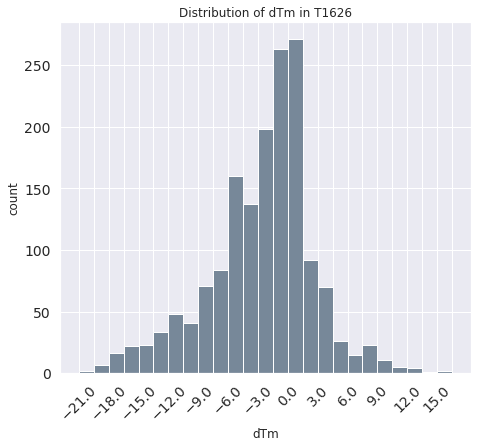

In [0]:
plot_hist_label(pd.Series(y_label),"dTm", "count", "Distribution of dTm in T1626", model_folder_loc+"distribution_of_dTm_T1626.png")

### Model paper: (contains ALG + E features) //2.561 MAE (S_E)

In [0]:
model_paper_results = n_trial_nested_k_fold_crossvalidation(X_paper.values, y_label.values)

Trials:  7
Evaluation metric:  mae
Inner folds:  3
Outer folds:  5
Bayesian init points:  15
Bayesian iterations:  10
Bayes acquisition function:  ei

Trial number:  1
Fold number:  1
|   iter    |  target   | colsam... |    eta    |   gamma   | max_depth | subsample |
-------------------------------------------------------------------------------------
|  1        | -2.674    |  0.6016   |  0.03383  |  0.0537   |  7.328    |  0.7635   |
|  2        | -2.806    |  0.7643   |  0.2832   |  0.2935   |  5.067    |  0.8559   |
|  3        | -2.834    |  0.9518   |  0.2416   |  0.7593   |  5.313    |  0.7975   |
|  4        | -2.983    |  0.5583   |  0.01254  |  0.4712   |  5.634    |  0.8909   |
|  5        | -2.854    |  0.697    |  0.2568   |  0.6236   |  9.847    |  0.8862   |
|  6        | -2.673    |  0.8253   |  0.07749  |  0.3247   |  8.73     |  0.8518   |
|  7        | -2.752    |  0.636    |  0.1644   |  0.882    |  8.065    |  0.8558   |
|  8        | -2.724    |  0.8363   |  0.1

In [0]:
model_paper_results.describe()

,colsample_bytree,eta,gamma,max_depth,subsample,scores_mae,scores_rmse
count,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000
mean,0.688064,0.074553,0.426338,6.571429,0.848623,2.561709,3.613911
std,0.139875,0.036843,0.297289,1.289909,0.071821,0.124323,0.188584
min,0.514375,0.030558,0.052595,5.000000,0.721651,2.218020,3.087298
25%,0.586535,0.042278,0.211259,5.500000,0.804292,2.512734,3.563750
50%,0.611662,0.063494,0.324713,6.000000,0.835002,2.559912,3.655913
75%,0.821043,0.102747,0.638675,7.500000,0.910856,2.636829,3.727937
max,0.958334,0.164828,0.975458,9.000000,0.988668,2.825232,4.099129


In [0]:
model_paper_results.to_pickle(model_folder_loc+"results_paper_own_baseline_xgboost_T1626.pkl")

### Model paper scaled: (contains ALG + E features) //2.568 MAE (S_E_s)

In [0]:
model_paper_scaled_results = n_trial_nested_k_fold_crossvalidation(X_paper.values, y_label.values, scale_label=True)

Trials:  7
Evaluation metric:  mae
Inner folds:  3
Outer folds:  5
Bayesian init points:  15
Bayesian iterations:  10
Bayes acquisition function:  ei

Trial number:  1
Fold number:  1
|   iter    |  target   | colsam... |    eta    |   gamma   | max_depth | subsample |
-------------------------------------------------------------------------------------
|  1        | -0.5048   |  0.6016   |  0.03383  |  0.0537   |  7.328    |  0.7635   |
|  2        | -0.5334   |  0.7643   |  0.2832   |  0.2935   |  5.067    |  0.8559   |
|  3        | -0.5349   |  0.9518   |  0.2416   |  0.7593   |  5.313    |  0.7975   |
|  4        | -0.5596   |  0.5583   |  0.01254  |  0.4712   |  5.634    |  0.8909   |
|  5        | -0.5458   |  0.697    |  0.2568   |  0.6236   |  9.847    |  0.8862   |
|  6        | -0.5149   |  0.8253   |  0.07749  |  0.3247   |  8.73     |  0.8518   |
|  7        | -0.5118   |  0.636    |  0.1644   |  0.882    |  8.065    |  0.8558   |
|  8        | -0.5132   |  0.8363   |  0.1

In [0]:
model_paper_scaled_results.describe()

,colsample_bytree,eta,gamma,max_depth,subsample,scores_mae,scores_rmse
count,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000
mean,0.691588,0.067247,0.373931,6.742857,0.810459,2.568680,3.624578
std,0.128397,0.030837,0.251792,1.313792,0.073221,0.129373,0.193691
min,0.500000,0.027898,0.007143,5.000000,0.700000,2.190758,3.035986
25%,0.596137,0.043444,0.228363,6.000000,0.749338,2.511704,3.549781
50%,0.640035,0.063494,0.316472,7.000000,0.810139,2.582213,3.664518
75%,0.802106,0.077161,0.585427,8.000000,0.835517,2.620722,3.715014
max,0.958334,0.140064,0.975458,9.000000,1.000000,2.862351,4.133851


In [0]:
model_paper_scaled_results.to_pickle(model_folder_loc+"results_paper_scaled_own_baseline_xgboost_T1626.pkl")

### Model paper  filtered: (contains ALG + E features) // 2.57 MAE (S_E_f)

In [0]:
model_paper_filtered_results = n_trial_nested_k_fold_crossvalidation(X_paper[unambiguous_mut_filter].values, y_label[unambiguous_mut_filter].values)

Trials:  7
Evaluation metric:  mae
Inner folds:  3
Outer folds:  5
Bayesian init points:  15
Bayesian iterations:  10
Bayes acquisition function:  ei

Trial number:  1
Fold number:  1
|   iter    |  target   | colsam... |    eta    |   gamma   | max_depth | subsample |
-------------------------------------------------------------------------------------
|  1        | -2.681    |  0.6016   |  0.03383  |  0.0537   |  7.328    |  0.7635   |
|  2        | -2.812    |  0.7643   |  0.2832   |  0.2935   |  5.067    |  0.8559   |
|  3        | -2.764    |  0.9518   |  0.2416   |  0.7593   |  5.313    |  0.7975   |
|  4        | -2.944    |  0.5583   |  0.01254  |  0.4712   |  5.634    |  0.8909   |
|  5        | -2.838    |  0.697    |  0.2568   |  0.6236   |  9.847    |  0.8862   |
|  6        | -2.654    |  0.8253   |  0.07749  |  0.3247   |  8.73     |  0.8518   |
|  7        | -2.792    |  0.636    |  0.1644   |  0.882    |  8.065    |  0.8558   |
|  8        | -2.718    |  0.8363   |  0.1

In [0]:
model_paper_filtered_results.describe()

,colsample_bytree,eta,gamma,max_depth,subsample,scores_mae,scores_rmse
count,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000
mean,0.668395,0.066158,0.418347,6.628571,0.845476,2.577013,3.630419
std,0.124731,0.031639,0.333451,1.262251,0.080742,0.150107,0.249851
min,0.514375,0.028099,0.007143,5.000000,0.721651,2.252446,3.121137
25%,0.586535,0.042547,0.223163,6.000000,0.786297,2.463592,3.469295
50%,0.601588,0.063112,0.244598,6.000000,0.824399,2.568162,3.588053
75%,0.773870,0.074252,0.765059,8.000000,0.903279,2.714451,3.862979
max,0.929034,0.150768,0.975458,9.000000,0.988668,2.858596,4.073837


In [0]:
model_paper_filtered_results.to_pickle(model_folder_loc+"results_paper_filtered_own_baseline_xgboost_T1626.pkl")

### Model paper ext: (ALG + E + HM)  //2.533 MAE (S_E_EXT)

In [0]:
model_paper_ext_results = n_trial_nested_k_fold_crossvalidation(X_paper_ext.values, y_label.values, inner_fold=3)

Trials:  7
Evaluation metric:  mae
Inner folds:  3
Outer folds:  5
Bayesian init points:  15
Bayesian iterations:  10
Bayes acquisition function:  ei

Trial number:  1
Fold number:  1
|   iter    |  target   | colsam... |    eta    |   gamma   | max_depth | subsample |
-------------------------------------------------------------------------------------
|  1        | -2.668    |  0.6016   |  0.03383  |  0.0537   |  7.328    |  0.7635   |
|  2        | -2.814    |  0.7643   |  0.2832   |  0.2935   |  5.067    |  0.8559   |
|  3        | -2.724    |  0.9518   |  0.2416   |  0.7593   |  5.313    |  0.7975   |
|  4        | -2.945    |  0.5583   |  0.01254  |  0.4712   |  5.634    |  0.8909   |
|  5        | -2.807    |  0.697    |  0.2568   |  0.6236   |  9.847    |  0.8862   |
|  6        | -2.64     |  0.8253   |  0.07749  |  0.3247   |  8.73     |  0.8518   |
|  7        | -2.75     |  0.636    |  0.1644   |  0.882    |  8.065    |  0.8558   |
|  8        | -2.718    |  0.8363   |  0.1

In [0]:
model_paper_ext_results.describe()

,colsample_bytree,eta,gamma,max_depth,subsample,scores_mae,scores_rmse
count,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000
mean,0.712577,0.076209,0.455180,6.514286,0.853838,2.533167,3.586387
std,0.147144,0.034582,0.320327,1.314432,0.078502,0.143191,0.197153
min,0.514375,0.033835,0.053701,5.000000,0.721651,2.180672,3.040009
25%,0.591336,0.043444,0.211259,5.000000,0.809113,2.441388,3.509064
50%,0.667982,0.070909,0.324713,6.000000,0.851849,2.545797,3.606479
75%,0.830292,0.107227,0.668153,8.000000,0.922530,2.599679,3.676825
max,0.958334,0.140064,0.988374,9.000000,0.988668,2.812650,4.033751


In [0]:
model_paper_ext_results.to_pickle(model_folder_loc+"results_paper_ext_own_baseline_xgboost_T1626.pkl")

### Model paper ext scaled: (ALG + E + HM) //2.522 MAE (S_E_EXT_s)

In [0]:
model_paper_ext_scaled_results = n_trial_nested_k_fold_crossvalidation(X_paper_ext.values, y_label.values, scale_label=True)

Trials:  7
Evaluation metric:  mae
Inner folds:  3
Outer folds:  5
Bayesian init points:  15
Bayesian iterations:  10
Bayes acquisition function:  ei

Trial number:  1
Fold number:  1
|   iter    |  target   | colsam... |    eta    |   gamma   | max_depth | subsample |
-------------------------------------------------------------------------------------
|  1        | -0.5063   |  0.6016   |  0.03383  |  0.0537   |  7.328    |  0.7635   |
|  2        | -0.5427   |  0.7643   |  0.2832   |  0.2935   |  5.067    |  0.8559   |
|  3        | -0.5241   |  0.9518   |  0.2416   |  0.7593   |  5.313    |  0.7975   |
|  4        | -0.5535   |  0.5583   |  0.01254  |  0.4712   |  5.634    |  0.8909   |
|  5        | -0.5328   |  0.697    |  0.2568   |  0.6236   |  9.847    |  0.8862   |
|  6        | -0.5023   |  0.8253   |  0.07749  |  0.3247   |  8.73     |  0.8518   |
|  7        | -0.514    |  0.636    |  0.1644   |  0.882    |  8.065    |  0.8558   |
|  8        | -0.5126   |  0.8363   |  0.1

In [0]:
model_paper_ext_scaled_results.describe()

,colsample_bytree,eta,gamma,max_depth,subsample,scores_mae,scores_rmse
count,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000
mean,0.700687,0.069992,0.536414,6.542857,0.853473,2.522487,3.567137
std,0.131316,0.031498,0.286244,1.335992,0.081158,0.144446,0.218537
min,0.514375,0.030558,0.181222,5.000000,0.721651,2.090491,2.938190
25%,0.583010,0.044341,0.278652,5.000000,0.810139,2.452409,3.486984
50%,0.679754,0.063112,0.437719,6.000000,0.835817,2.523736,3.567614
75%,0.807796,0.080402,0.836807,8.000000,0.934205,2.594330,3.717819
max,0.958334,0.140064,0.975458,9.000000,0.988668,2.822308,4.157220


In [0]:
model_paper_ext_scaled_results.to_pickle(model_folder_loc+"results_paper_ext_scaled_own_baseline_xgboost_T1626.pkl")

### Model paper cart-tie: (contains ALG + Cart-tiE features) //2.791 MAE (S_CART)

In [0]:
model_paper_cart_tie_unscaled_results = n_trial_nested_k_fold_crossvalidation(X_paper_cart_tie.values, y_label.values)

Trials:  7
Evaluation metric:  mae
Inner folds:  3
Outer folds:  5
Bayesian init points:  15
Bayesian iterations:  10
Bayes acquisition function:  ei

Trial number:  1
Fold number:  1
|   iter    |  target   | colsam... |    eta    |   gamma   | max_depth | subsample |
-------------------------------------------------------------------------------------
|  1        | -2.882    |  0.6016   |  0.03383  |  0.0537   |  7.328    |  0.7635   |
|  2        | -3.113    |  0.7643   |  0.2832   |  0.2935   |  5.067    |  0.8559   |
|  3        | -3.043    |  0.9518   |  0.2416   |  0.7593   |  5.313    |  0.7975   |
|  4        | -3.135    |  0.5583   |  0.01254  |  0.4712   |  5.634    |  0.8909   |
|  5        | -3.017    |  0.697    |  0.2568   |  0.6236   |  9.847    |  0.8862   |
|  6        | -2.901    |  0.8253   |  0.07749  |  0.3247   |  8.73     |  0.8518   |
|  7        | -2.949    |  0.636    |  0.1644   |  0.882    |  8.065    |  0.8558   |
|  8        | -2.951    |  0.8363   |  0.1

In [0]:
model_paper_cart_tie_unscaled_results.describe()

,colsample_bytree,eta,gamma,max_depth,subsample,scores_mae,scores_rmse
count,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000
mean,0.643667,0.053234,0.481125,6.828571,0.855851,2.791047,3.866507
std,0.098683,0.023940,0.350982,1.248192,0.081272,0.131674,0.189158
min,0.514375,0.028099,0.007143,5.000000,0.733678,2.465267,3.433139
25%,0.564681,0.039667,0.236177,6.000000,0.793938,2.728268,3.757217
50%,0.601588,0.044341,0.324713,7.000000,0.851849,2.793204,3.857859
75%,0.730271,0.063112,0.895550,8.000000,0.915930,2.850303,3.973340
max,0.825265,0.130599,0.994690,9.000000,0.988668,3.141850,4.355352


In [0]:
model_paper_cart_tie_unscaled_results.to_pickle(model_folder_loc+"results_paper_cart_tie_own_baseline_xgboost_T1626.pkl")

### Model paper cart-tie scaled: (contains ALG + Cart-tiE features) //2.795 MAE (S_CART_s)

In [0]:
model_paper_cart_tie_results = n_trial_nested_k_fold_crossvalidation(X_paper_cart_tie.values, y_label.values, scale_label=True)

Trials:  7
Evaluation metric:  mae
Inner folds:  3
Outer folds:  5
Bayesian init points:  15
Bayesian iterations:  10
Bayes acquisition function:  ei

Trial number:  1
Fold number:  1
|   iter    |  target   | colsam... |    eta    |   gamma   | max_depth | subsample |
-------------------------------------------------------------------------------------
|  1        | -0.5468   |  0.6016   |  0.03383  |  0.0537   |  7.328    |  0.7635   |
|  2        | -0.586    |  0.7643   |  0.2832   |  0.2935   |  5.067    |  0.8559   |
|  3        | -0.5734   |  0.9518   |  0.2416   |  0.7593   |  5.313    |  0.7975   |
|  4        | -0.5897   |  0.5583   |  0.01254  |  0.4712   |  5.634    |  0.8909   |
|  5        | -0.5866   |  0.697    |  0.2568   |  0.6236   |  9.847    |  0.8862   |
|  6        | -0.5472   |  0.8253   |  0.07749  |  0.3247   |  8.73     |  0.8518   |
|  7        | -0.5681   |  0.636    |  0.1644   |  0.882    |  8.065    |  0.8558   |
|  8        | -0.5579   |  0.8363   |  0.1

In [0]:
model_paper_cart_tie_results.describe()

,colsample_bytree,eta,gamma,max_depth,subsample,scores_mae,scores_rmse
count,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000
mean,0.669577,0.057194,0.437976,6.857143,0.842764,2.795769,3.873913
std,0.124087,0.024136,0.305131,1.286648,0.078596,0.131657,0.185134
min,0.514375,0.030558,0.007143,5.000000,0.726353,2.537838,3.424552
25%,0.583010,0.040438,0.232246,6.000000,0.770609,2.741807,3.782098
50%,0.640035,0.050837,0.354903,7.000000,0.824399,2.783450,3.886723
75%,0.752707,0.070693,0.638675,8.000000,0.914156,2.836988,3.959819
max,0.958334,0.132985,0.975458,9.000000,0.988668,3.112198,4.323391


In [0]:
model_paper_cart_tie_results.to_pickle(model_folder_loc+"results_paper_cart_tie_scaled_own_baseline_xgboost_T1626.pkl")

## Evaulate different models (with 5-fold nested Bayesian optimization)


### Model paper: (contains ALG + E features) //5-fold inner //2.557 MAE (S_E)

In [0]:
model_paper_5fold_results = n_trial_nested_k_fold_crossvalidation(X_paper.values, y_label.values, inner_fold=5)

Trials:  7
Evaluation metric:  mae
Inner folds:  5
Outer folds:  5
Bayesian init points:  15
Bayesian iterations:  10
Bayes acquisition function:  ei

Trial number:  1
Fold number:  1
|   iter    |  target   | colsam... |    eta    |   gamma   | max_depth | subsample |
-------------------------------------------------------------------------------------
|  1        | -2.674    |  0.6016   |  0.03383  |  0.0537   |  7.328    |  0.7635   |
|  2        | -2.799    |  0.7643   |  0.2832   |  0.2935   |  5.067    |  0.8559   |
|  3        | -2.847    |  0.9518   |  0.2416   |  0.7593   |  5.313    |  0.7975   |
|  4        | -2.969    |  0.5583   |  0.01254  |  0.4712   |  5.634    |  0.8909   |
|  5        | -2.864    |  0.697    |  0.2568   |  0.6236   |  9.847    |  0.8862   |
|  6        | -2.701    |  0.8253   |  0.07749  |  0.3247   |  8.73     |  0.8518   |
|  7        | -2.732    |  0.636    |  0.1644   |  0.882    |  8.065    |  0.8558   |
|  8        | -2.776    |  0.8363   |  0.1

In [0]:
model_paper_5fold_results.describe()

,colsample_bytree,eta,gamma,max_depth,subsample,scores_mae,scores_rmse
count,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000
mean,0.641889,0.066300,0.379827,6.514286,0.864205,2.557404,3.603472
std,0.122673,0.032458,0.292281,1.221653,0.080124,0.128477,0.195329
min,0.514375,0.030558,0.007143,5.000000,0.743399,2.193708,3.056440
25%,0.548411,0.040438,0.181222,6.000000,0.810139,2.500034,3.521517
50%,0.601588,0.051300,0.278652,6.000000,0.880416,2.555345,3.605602
75%,0.693795,0.086556,0.581459,7.500000,0.927142,2.627732,3.692401
max,0.958334,0.140064,0.975458,9.000000,0.988668,2.857414,4.200471


In [0]:
model_paper_5fold_results.to_pickle(model_folder_loc+"results_paper_5fold_own_baseline_xgboost_T1626.pkl")

### Model paper ext: (ALG + E + HM) //HM = Tm, PH, LEN, T //5-fold inner //2.543 MAE (S_E_EXT)

In [0]:
model_paper_ext_5fold_results = n_trial_nested_k_fold_crossvalidation(X_paper_ext.values, y_label.values, inner_fold=5)

Trials:  7
Evaluation metric:  mae
Inner folds:  5
Outer folds:  5
Bayesian init points:  15
Bayesian iterations:  10
Bayes acquisition function:  ei

Trial number:  1
Fold number:  1
|   iter    |  target   | colsam... |    eta    |   gamma   | max_depth | subsample |
-------------------------------------------------------------------------------------
|  1        | -2.632    |  0.6016   |  0.03383  |  0.0537   |  7.328    |  0.7635   |
|  2        | -2.765    |  0.7643   |  0.2832   |  0.2935   |  5.067    |  0.8559   |
|  3        | -2.818    |  0.9518   |  0.2416   |  0.7593   |  5.313    |  0.7975   |
|  4        | -2.956    |  0.5583   |  0.01254  |  0.4712   |  5.634    |  0.8909   |
|  5        | -2.868    |  0.697    |  0.2568   |  0.6236   |  9.847    |  0.8862   |
|  6        | -2.605    |  0.8253   |  0.07749  |  0.3247   |  8.73     |  0.8518   |
|  7        | -2.777    |  0.636    |  0.1644   |  0.882    |  8.065    |  0.8558   |
|  8        | -2.658    |  0.8363   |  0.1

In [0]:
model_paper_ext_5fold_results.describe()

,colsample_bytree,eta,gamma,max_depth,subsample,scores_mae,scores_rmse
count,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000
mean,0.689247,0.074303,0.453230,6.800000,0.840952,2.543301,3.586723
std,0.132367,0.030659,0.271609,1.430755,0.080454,0.135905,0.204383
min,0.514375,0.030558,0.181222,5.000000,0.721651,2.180672,3.040009
25%,0.596137,0.051572,0.244598,5.500000,0.804805,2.488243,3.479243
50%,0.640035,0.070909,0.354903,7.000000,0.824399,2.552678,3.604058
75%,0.807796,0.093029,0.638675,8.000000,0.910493,2.602003,3.696723
max,0.942079,0.140064,0.975458,9.000000,0.988668,2.812650,4.033751


In [0]:
model_paper_ext_5fold_results.to_pickle(model_folder_loc+"results_paper_ext_5fold_own_baseline_xgboost_T1626.pkl")

### Model paper cart-tie: (contains ALG + Cart-tiE features)  //5-fold-inner //2.795 MAE (S_CART)

In [0]:
model_paper_cart_tie_5fold_results = n_trial_nested_k_fold_crossvalidation(X_paper_cart_tie.values, y_label.values, inner_fold=5)

Trials:  7
Evaluation metric:  mae
Inner folds:  5
Outer folds:  5
Bayesian init points:  15
Bayesian iterations:  10
Bayes acquisition function:  ei

Trial number:  1
Fold number:  1
|   iter    |  target   | colsam... |    eta    |   gamma   | max_depth | subsample |
-------------------------------------------------------------------------------------
|  1        | -2.86     |  0.6016   |  0.03383  |  0.0537   |  7.328    |  0.7635   |
|  2        | -3.048    |  0.7643   |  0.2832   |  0.2935   |  5.067    |  0.8559   |
|  3        | -2.937    |  0.9518   |  0.2416   |  0.7593   |  5.313    |  0.7975   |
|  4        | -3.124    |  0.5583   |  0.01254  |  0.4712   |  5.634    |  0.8909   |
|  5        | -3.042    |  0.697    |  0.2568   |  0.6236   |  9.847    |  0.8862   |
|  6        | -2.858    |  0.8253   |  0.07749  |  0.3247   |  8.73     |  0.8518   |
|  7        | -2.946    |  0.636    |  0.1644   |  0.882    |  8.065    |  0.8558   |
|  8        | -2.935    |  0.8363   |  0.1

In [0]:
model_paper_cart_tie_5fold_results.describe()

,colsample_bytree,eta,gamma,max_depth,subsample,scores_mae,scores_rmse
count,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000
mean,0.637102,0.064521,0.327662,6.771429,0.850215,2.795335,3.879798
std,0.107750,0.028052,0.290827,1.139807,0.083852,0.116374,0.173445
min,0.514375,0.026684,0.007143,5.000000,0.721651,2.520543,3.540303
25%,0.567473,0.040438,0.161309,6.000000,0.799090,2.728697,3.763005
50%,0.601588,0.056826,0.243991,7.000000,0.824399,2.793204,3.872159
75%,0.730271,0.089072,0.357340,8.000000,0.892402,2.860343,3.987270
max,0.835319,0.118135,0.975458,9.000000,0.988668,3.149969,4.374738


In [0]:
model_paper_cart_tie_5fold_results.to_pickle(model_folder_loc+"results_paper_cart_tie_5fold_own_baseline_xgboost_T1626.pkl")

##Results


In [0]:
model = ["S_E","S_E_s","S_E_f","S_E_EXT","S_E_EXT_s","S_CART","S_CART_s"]
value = [[2.561709,3.613911],
         [2.568680,3.624578],
        [2.577013,3.630419],
         [2.533167,3.586387],
         [2.522487,3.567137],
         [2.791047,3.866507],
         [2.795769,3.873913]
        ]
std = [[0.124323,0.188584],
      [0.129373,0.193691],
       [0.150107,0.249851],
      [0.143191,0.197153],
      [0.144446,0.218537],
      [0.131674,0.189158],
      [0.131657,0.185134]]
measure = ["MAE","RMSE"]

values_df = pd.DataFrame(value)
values_df.columns=measure
values_df.index=model

std_df = pd.DataFrame(std)
std_df.columns=measure
std_df.index=model

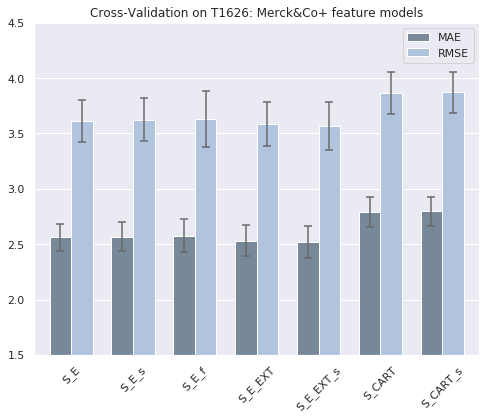

In [0]:
plot_results_bar_err(results_df=values_df,std_df=std_df,title="Cross-Validation on T1626: Merck&Co+ feature models",saveloc=model_folder_loc+"paper_features_performance_NEW.png", fig_size=(7,6), fig_lim=(1.5,4.5))

In [0]:
std_df.columns = list(map(lambda x: x+"_std",std_df.columns))
results = pd.concat([values_df,std_df], axis=1)
results = results.round(3)

In [0]:
results

,MAE,RMSE,MAE_std,RMSE_std
S_E,2.562,3.614,0.124,0.189
S_E_s,2.569,3.625,0.129,0.194
S_E_f,2.577,3.630,0.150,0.250
S_E_EXT,2.533,3.586,0.143,0.197
S_E_EXT_s,2.522,3.567,0.144,0.219
S_CART,2.791,3.867,0.132,0.189
S_CART_s,2.796,3.874,0.132,0.185


In [0]:
results.to_csv(model_folder_loc+"paper_features_results_table_NEW.csv")